In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import mean_squared_error, r2_score #model evaluation

%matplotlib inline

## Load in Beyonce Spotify Data

In [2]:
b = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Beyonce_data.csv")
predictors = ["energy", "key", "loudness", "speechiness",
              "acousticness", "instrumentalness", "liveness", "valence"]

cont_pred = ["energy","loudness", "speechiness",
              "acousticness", "instrumentalness", "liveness", "valence"]
X = b[predictors]
y = b["danceability"]

### Plot Raw Values for Energy and Danceability

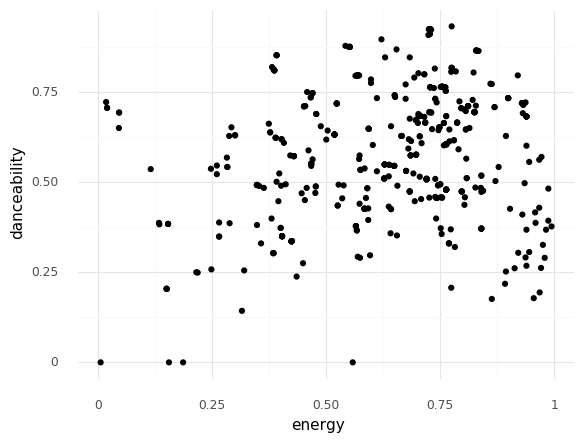

<ggplot: (8774948194413)>

In [3]:
ggplot(b, aes(x = "energy", y = "danceability")) + geom_point() + theme_minimal()

In [4]:
# Z score
Xz = b[predictors]

# x
z = StandardScaler()
Xz[cont_pred] = z.fit_transform(X[cont_pred])

# all data
bz = b
bz[cont_pred] = z.fit_transform(X[cont_pred])

### Plot Raw and Z scored Data

Notice that now that we've z scored danceability, the pattern is EXACTLY the same as in the scatterplot above, but the numbers on the x axis are different!

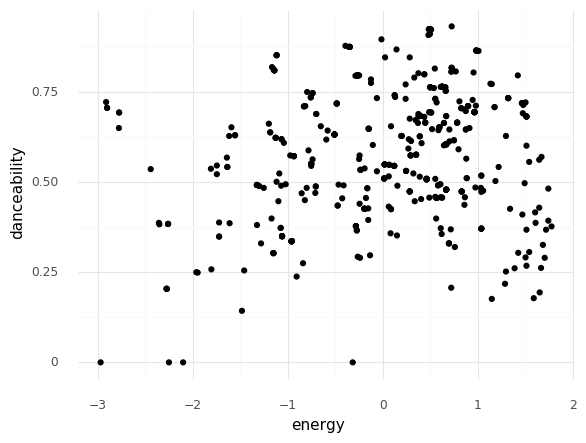

<ggplot: (8774944205237)>

In [5]:
ggplot(bz, aes(x = "energy", y = "danceability")) + geom_point() + theme_minimal()

## Building Models

In [6]:
# fit a model where the predictors are RAW and one where the predictors are z scored
m = LinearRegression()
mz = LinearRegression()

m.fit(X,y)
mz.fit(Xz,y)

print("Regular performance", m.score(X,y))
print("Regular performance", mz.score(Xz,y))

Regular performance 0.5994967241704979
Regular performance 0.5994967241704979


Note that above, the two models have the SAME performance, despite using different scales for the predictors. 

Now let's look at the coefficients.

### Coefs

Note that the coefficients are different, this is because for z-scored variables, coefs are in terms of 1 *standard deviation* change in the variable, whereas for the raw variables, it's a 1 unit change.

In [7]:
coef = pd.DataFrame({"raw_vars": m.coef_, "z_vars": mz.coef_, "names": predictors})
coef

,raw_vars,z_vars,names
0,-0.167316,-0.034829,energy
1,-0.001462,-0.001462,key
2,0.006526,0.022993,loudness
3,-0.001998,-0.000301,speechiness
4,-0.283249,-0.068482,acousticness
5,-0.067339,-0.007033,instrumentalness
6,-0.137423,-0.029896,liveness
7,0.406068,0.091860,valence


## Simulation

The simulation below simulates 3 predictors, `a`, `b`, and `c`, and an outcome `y`. Then it builds a model with the raw values, and the z scored values, and returns the coefficients and performance for both models. 

In [8]:
def simZScore(n = 100):
    a = np.random.normal(size = n,
                         loc = np.random.normal(size = 1),
                         scale = np.random.uniform(size = 1,low = 0.1,high = 10))
    b = np.random.normal(size = n,
                         loc = np.random.normal(size = 1),
                         scale = np.random.uniform(size = 1,low = 0.1,high = 10))
    c = np.random.normal(size = n,
                         loc = np.random.normal(size = 1),
                         scale = np.random.uniform(size = 1,low = 0.1,high = 10))

    y = a * 1.5 - b * 0.2 + c * 0.001 + np.random.normal(n)
    
    X = pd.DataFrame({"a": a, "b": b, "c": c})
    
    z = StandardScaler()
    
    Xz = z.fit_transform(X)

    m = LinearRegression()
    mz = LinearRegression()

    m.fit(X,y)
    mz.fit(Xz,y)

    raw_score = m.score(X,y)
    z_score = mz.score(Xz,y)
    coefs = pd.DataFrame({"names": ["a", "b", "c"], "raw": m.coef_, "zscored": mz.coef_,
                         "different": m.coef_ != mz.coef_})
    scores = pd.DataFrame({"raw_score": [raw_score], "z_score": [z_score], "different": [raw_score - z_score != 0]})
    return({"coefs": coefs, "scores": scores})
    


In [9]:
# run the simulation
results = [simZScore() for i in range(0,1000)]

# put all data together
coefs = pd.concat([i["coefs"] for i in results])
scores = pd.concat([i["scores"] for i in results])

In [10]:
coefs.head()

,names,raw,zscored,different
0,a,1.500,1.306056,True
1,b,-0.200,-1.691996,True
2,c,0.001,0.006054,True
0,a,1.500,0.247273,True
1,b,-0.200,-1.121715,True


In [11]:
scores.head()

,raw_score,z_score,different
0,1.0,1.0,False
0,1.0,1.0,False
0,1.0,1.0,False
0,1.0,1.0,False
0,1.0,1.0,False


Note that the coefficients are ALWAYS different between the models, but the score NEVER is!

In [12]:
np.mean(coefs.different)

1.0

In [13]:
np.mean(scores.different)

0.0